In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# os.chdir("../../..")
import copy
import pathlib
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 42
pl.seed_everything(RANDOM_STATE)

Global seed set to 42


42

In [3]:
%load_ext autoreload
%autoreload 2

from helper_functions import utils, data_pipeline, visualization

In [4]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"
saved_model_dir = root_dir / "models"
secret_dir = root_dir / "secrets"

In [5]:
# RepeatingBasisFunction from scikit-lego
# https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/

# Data Preprocessing

In [5]:
raw_data = pd.read_csv(processed_data_dir / "klhk_usable_linearimputed_coord.csv")
with pd.option_context('display.max_rows', 2, 'display.max_columns', None): 
    display(raw_data)

,OID_,klhk_usable_linearimputed_csv_Field1,klhk_usable_linearimputed_csv_stasiun,klhk_usable_linearimputed_csv_pm10,pm2_5,klhk_usable_linearimputed_csv_so2,klhk_usable_linearimputed_csv_co,klhk_usable_linearimputed_csv_o3,klhk_usable_linearimputed_csv_no2,klhk_usable_linearimputed_csv_hc,pm_2_5_sedang,pm_2_5_tidak_sehat,klhk_usable_linearimputed_csv_read_time,klhk_usable_linearimputed_csv_lin_pm25,XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_No,XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Nama_Stasi,XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Alamat,XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Kota___Kab,XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Provinsi,XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Latitude,XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Longitude,XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_KETERANGAN
0,1,1992,Bekasi Kayuringin,62.0,96.0,40.0,15.0,45.0,28.0,70.0,55.4,150.4,01/06/2023 00:00:00,96.0,2,Bekasi Kayuringin,"Stadium Patriot Candrabaga, Kayuringin Jaya, B...",Kota Bekasi,Jawa Barat,-6.237452,106.992943,KLHK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13823,13824,39047,Tangerang Pasir Jaya,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.4,150.4,04/09/2023 23:00:00,98.0,4,Tangerang Pasir Jaya,"Jl. Gajah Tunggal, RT.001/RW.004, Jatake, Kec....",Kota Tangerang,Banten,-6.197491,106.570475,KLHK


<AxesSubplot:xlabel='klhk_usable_linearimputed_csv_lin_pm25', ylabel='Count'>

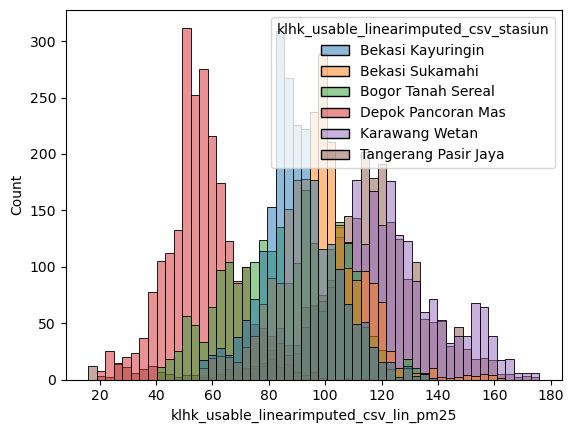

In [6]:
sns.histplot(
    x=raw_data['klhk_usable_linearimputed_csv_lin_pm25'], 
    hue=raw_data['klhk_usable_linearimputed_csv_stasiun']
)

In [7]:
col_remap = {
    'klhk_usable_linearimputed_csv_stasiun':'stasiun',
    'klhk_usable_linearimputed_csv_lin_pm25':'pm25',
    'klhk_usable_linearimputed_csv_read_time':'read_time',
    'XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Latitude':'longitude',
    'XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Longitude':'latitude'
    }

## Create datetime features

In [8]:
# rename columns and use only important columns
processed_data = raw_data[col_remap.keys()].rename(columns=col_remap).drop(columns=['longitude','latitude'])

# drop some data from a stasiun
to_drop = np.arange(9201,processed_data[processed_data['stasiun'] == 'Depok Pancoran Mas'].index.max()+1)
processed_data = processed_data.drop(to_drop)

# convert to datetime
processed_data['read_time'] = pd.to_datetime(processed_data['read_time'], format="%d/%m/%Y %H:%M:%S")
processed_data_x, processed_data_y = data_pipeline.create_dt_features(processed_data, target_variable='pm25', dt_col='read_time')
# processed_data_x["month"] = processed_data_x['month'].astype(str).astype("category")  # categories have be strings
# processed_data_x["quarter"] = processed_data_x['quarter'].astype(str).astype("category")  # categories have be strings

# # cycle encoding
# for granularity, max in zip(['hour','dayofweek','dayofmonth'],[23,6,30]):
#         encode(processed_data_x, granularity, max)

# add time index
processed_data_x['time_idx'] = processed_data_x.groupby('stasiun').cumcount() + 1

# drop read_time
processed_data_x = processed_data_x.drop(columns=['read_time'])

In [9]:
with pd.option_context('display.max_rows', 2, 'display.max_columns', None):
    display(processed_data_x)

,stasiun,pm25,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,time_idx
0,Bekasi Kayuringin,96.0,0,3,2,6,2023,152,1,22,1
...,...,...,...,...,...,...,...,...,...,...,...
13823,Tangerang Pasir Jaya,98.0,23,0,3,9,2023,247,4,36,2304


## Train test split

In [10]:
# Define the proportions for train, validation, and test sets
train_frac = 0.8  # 60% of the data for training
test_frac = 0.2   # 20% for testing

# X_train, X_test, y_train, y_test = train_test_split(
#     processed_data_x,
#     processed_data_y,
#     test_size=test_frac,
#     # stratify=processed_data_x['stasiun'],
#     random_state=RANDOM_STATE, shuffle=False)

stasiun_counts = processed_data_x['stasiun'].value_counts()

# Initialize empty DataFrames for training and testing sets.
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# Iterate through unique 'stasiun' values and split data proportionally.
for stasiun, count in stasiun_counts.items():
    stasiun_data = processed_data_x[processed_data_x['stasiun'] == stasiun]
    train_data, test_data = train_test_split(stasiun_data, test_size=int(count * test_frac), random_state=42, shuffle=False)
    
    # Append the split data to the respective DataFrames.
    train_df = train_df.append(train_data).sort_index()
    test_df = test_df.append(test_data).sort_index()

In [11]:
with pd.option_context('display.max_rows', 2, 'display.max_columns', None):
    display(train_df)

,stasiun,pm25,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,time_idx
0,Bekasi Kayuringin,96.0,0,3,2,6,2023,152,1,22,1
...,...,...,...,...,...,...,...,...,...,...,...
13363,Tangerang Pasir Jaya,126.0,19,2,3,8,2023,228,16,33,1844


In [26]:
time_varying_known_reals_list = [
    'hour','dayofweek',
    'quarter',
    'month',
    'year',
    'dayofyear',
    'dayofmonth',
    'weekofyear',
    # 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
    # 'dayofmonth_sin', 'dayofmonth_cos', 
    'time_idx'
    ]

## Create TimeSeriesDataSet

In [13]:
min_prediction_length = 24//2
max_prediction_length = 24*7
max_encoder_length = max_prediction_length * 3
training_cutoff = train_df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    train_df[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='pm25',
    group_ids=['stasiun'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['stasiun'],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    # time_varying_known_categoricals=["quarter","month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=time_varying_known_reals,
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['pm25'],
    # target_normalizer=GroupNormalizer(
    #     groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last 
# max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, train_df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [14]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True, )
MAE()(baseline_predictions.output, baseline_predictions.y)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(11., device='cuda:0')

## Find optimal Learning Rate with `Tuner`

In [15]:
# configure network and trainer
# pl.seed_everything(42)
trainer = pl.Trainer(
    # accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 13.7k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 4.57088189614875e-06
Restoring states from the checkpoint path at d:\0_amri_local\11_aqi_forecast\notebooks\.lr_find_d56f0f3a-0353-47e5-8367-8305d27045c4.ckpt
Restored all states from the checkpoint at d:\0_amri_local\11_aqi_forecast\notebooks\.lr_find_d56f0f3a-0353-47e5-8367-8305d27045c4.ckpt


suggested learning rate: 4.57088189614875e-06


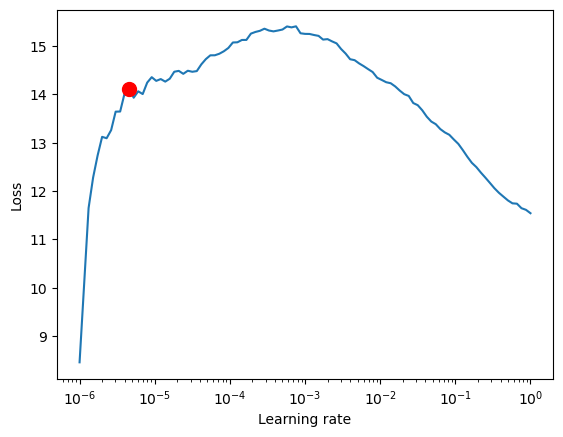

In [16]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# Experimentation

Hyperparameters to tune:
- learning_rate_range=(0.001, 0.1)
- hidden_size_range=(8, 128)
- dropout_range=(0.1, 0.3)
- gradient_clip_val_range=(0.01, 1.0)
- hidden_continuous_size_range=(8, 128)
- attention_head_size_range=(1, 4)

## Optuna (built-in)

In [ ]:
# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=2,
#     max_epochs=3,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

## TensorBoard

In [57]:
from pytorch_lightning import loggers as pl_loggers
tensorboard = pl_loggers.TensorBoardLogger('./')
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

In [58]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = pl.Trainer(
    max_epochs=3,
    # accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=10,  # comment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=tensorboard,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


In [59]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 24    
3  | prescalers                         | ModuleDict                      | 224   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 6.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## MLflow + Optuna

In [25]:
from pprint import pformat
import mlflow
import json
from helper_functions import tft_helper
# from lightning.pytorch.loggers import MLFlowLogger

In [99]:
with open(secret_dir/"mlflow_dagshub.json", "r") as f:
    secrets = json.load(f)

os.environ['MLFLOW_TRACKING_USERNAME'] = secrets['MLFLOW_TRACKING_USERNAME']
os.environ['MLFLOW_TRACKING_PASSWORD'] = secrets['MLFLOW_TRACKING_PASSWORD']
os.environ['MLFLOW_TRACKING_URI'] = secrets['MLFLOW_TRACKING_URI']

In [107]:
experiment_name = "test_tft_mlflow"

# Check if the experiment exists, and if not, create it
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# mlf_logger = MLFlowLogger(experiment_name=experiment_name)

### New version

https://github.com/StefanieStoppel/pytorch-mlflow-optuna/blob/tutorial-basics/mlflow-optuna-pytorch.ipynb

In [ ]:
batch_size = 32  # set this between 32 to 128
time_varying_known_reals_list = [
    'hour','dayofweek',
    'quarter',
    'month',
    'year',
    'dayofyear',
    'dayofmonth',
    'weekofyear',
    # 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
    # 'dayofmonth_sin', 'dayofmonth_cos', 
    'time_idx'
    ]

In [20]:
# Obtain hyperparameters for this trial
def suggest_hyperparameters(trial):
    # TimeSeriesDataset hparams
    min_prediction_length = trial.suggest_int("min_prediction_length", 12,12*6,12) # half a day to 3 days
    max_prediction_length = trial.suggest_int("max_prediction_length", 24,24*7,24) # a day to 7 days
    
    # pl.Trainer hparams
    gradient_clip_val = trial.suggest_float("gradient_clip_val", 1e-5, 1e-1)
    
    # TemporalFusionTransformer.from_dataset hparams
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
    hidden_size = trial.suggest_int("hidden_size", 8, 256)
    attention_head_size = trial.suggest_int("attention_head_size", 1, 8, 1)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    hidden_continuous_size=trial.suggest_int("hidden_continuous_size", 8, 128)
    
    print(f"Suggested hyperparameters: \n{pformat(trial.params)}")
    return (
        min_prediction_length,
        max_prediction_length,
        gradient_clip_val,
        lr,
        hidden_size,
        attention_head_size,
        dropout,
        hidden_continuous_size,
    )

In [ ]:
def objective(trial):
    print("\n********************************\n")
    mlflow.pytorch.autolog()
    # Start a new mlflow run
    with mlflow.start_run(experiment_id=experiment_id):
        # Get hyperparameter suggestions created by optuna and log them as params using mlflow
        (
            min_prediction_length,
            max_prediction_length,
            gradient_clip_val,
            lr,
            hidden_size,
            attention_head_size,
            dropout,
            hidden_continuous_size,
        ) = suggest_hyperparameters(trial)
        mlflow.log_params({
            "min_prediction_length":min_prediction_length,
            "max_prediction_length":max_prediction_length,
            "gradient_clip_val":gradient_clip_val,
            "hidden_size":hidden_size,
            "attention_head_size":attention_head_size,
            "dropout":dropout,
            "hidden_continuous_size":hidden_continuous_size,
            })
        
        # Create TimeSeriesDataSet
        training = tft_helper.generate_dataset(
            train_df=train_df,
            time_varying_known_reals=time_varying_known_reals_list,
            min_prediction_length=min_prediction_length,
            max_prediction_length=max_prediction_length
        )
        
        # create validation set (predict=True) which means to predict the last 
        # max_prediction_length points in time for each series
        validation = TimeSeriesDataSet.from_dataset(
            training, train_df, predict=True, stop_randomization=True
            )

        # create dataloaders for model
        train_dataloader = training.to_dataloader(
            train=True, batch_size=batch_size, num_workers=0
            )
        val_dataloader = validation.to_dataloader(
            train=False, batch_size=batch_size, num_workers=0
            )
        
        trainer = pl.Trainer(
            max_epochs=100,
            accelerator="cpu",
            enable_model_summary=True,
            gradient_clip_val=gradient_clip_val,
            limit_train_batches=10,  # coment in for training, running valiation every 10 batches
        )

        tft = TemporalFusionTransformer.from_dataset(
            training,
            hidden_size=hidden_size,
            learning_rate=lr,
            attention_head_size=attention_head_size,
            dropout=dropout,
            hidden_continuous_size=hidden_continuous_size,
            loss=QuantileLoss(),
            optimizer="Ranger",
            reduce_on_plateau_patience=10,
        )
        
        trainer.fit(
            tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader,
            
        )
        
        
        
        callback_metric = trainer.callback_metrics
        
        # mlflow.log_metric("avg_train_losses", avg_train_loss, step=epoch)
        # mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch)
    # Return the best validation loss achieved by the network.
    # This is needed as Optuna needs to know how the suggested hyperparameters are influencing the network loss.
    mlflow.end_run()
    return callback_metric['val_loss'].item()

### Old version

In [108]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = pl.Trainer(
    max_epochs=3,
    # accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=10,  # comment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    # logger=tensorboard,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 29.7k


In [109]:
mlflow.pytorch.autolog()  # Automatically log PyTorch metrics
with mlflow.start_run(experiment_id=experiment_id):
    # for epoch in range(100):  # Adjust the number of epochs as needed
    # fit network
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    # # Log metrics after each epoch
    # train_smape = trainer.callback_metrics['train_SMAPE']
    # val_smape = trainer.callback_metrics['val_SMAPE']

    # mlflow.log_metrics({
    #     "train_smape": train_smape,
    #     "val_smape": val_smape,
    # }, step=epoch)

    # # Save the trained model as an artifact
    # mlflow.pytorch.log_model(tft, "model")

mlflow.end_run()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 24    
3  | prescalers                         | ModuleDict                      | 224   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 6.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Inference

need to read this<br>
find out how to extract the prediction output<br>
https://medium.com/@mouna.labiadh/forecasting-book-sales-with-temporal-fusion-transformer-dd482a7a257c

In [67]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [68]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader,
    return_y=True,
    # trainer_kwargs=dict(accelerator="cpu")
    )
MAE()(predictions.output, predictions.y)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(10.0720, device='cuda:0')

In [69]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


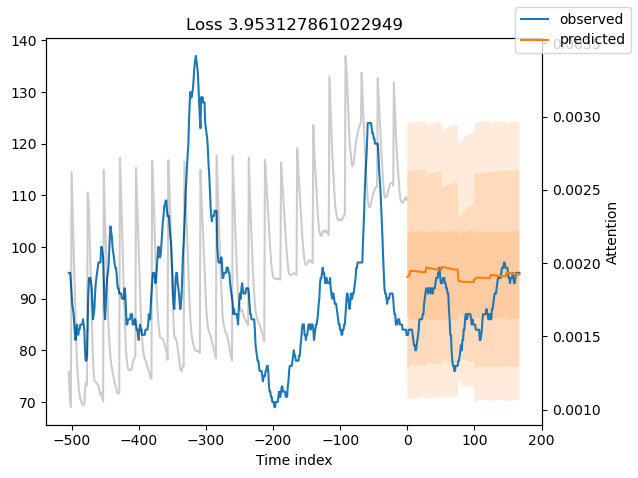

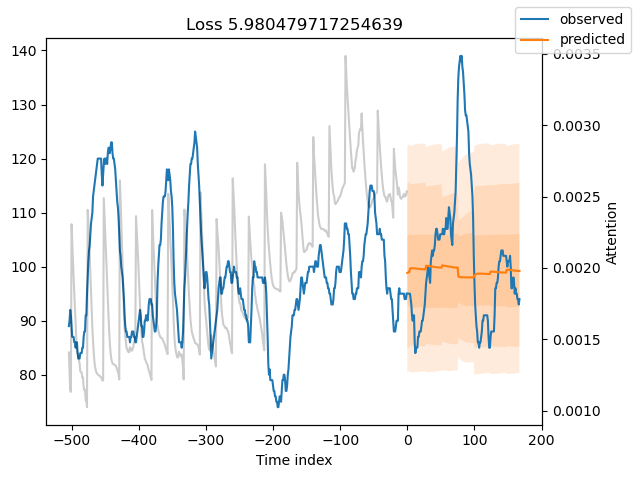

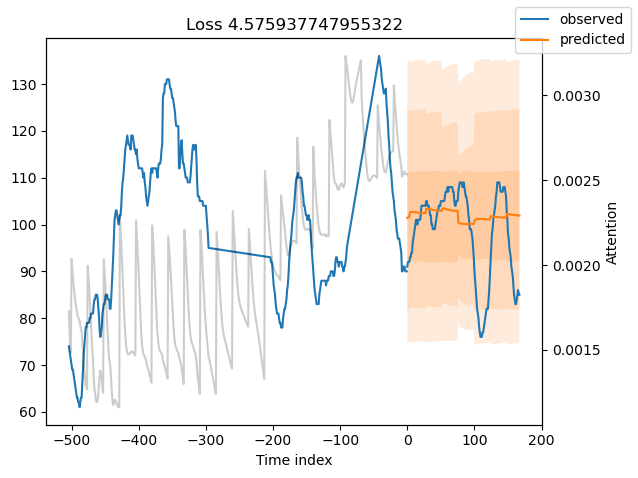

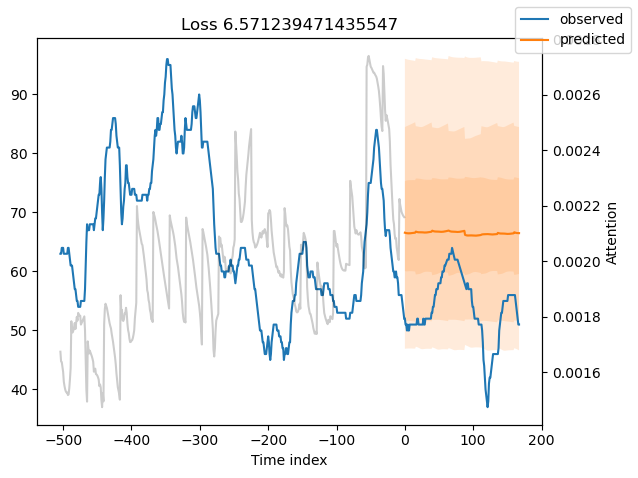

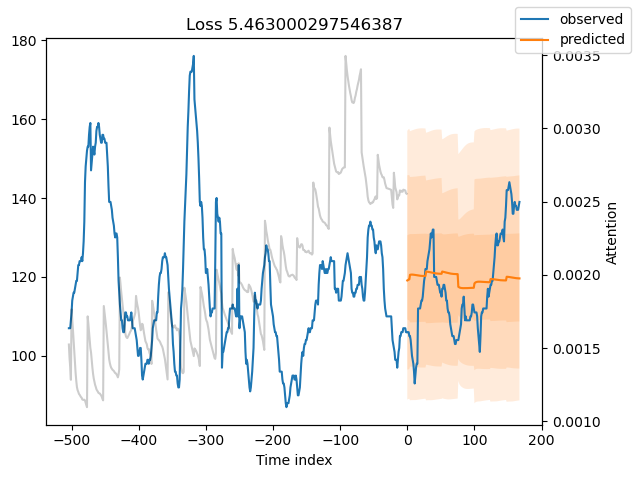

In [70]:
for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


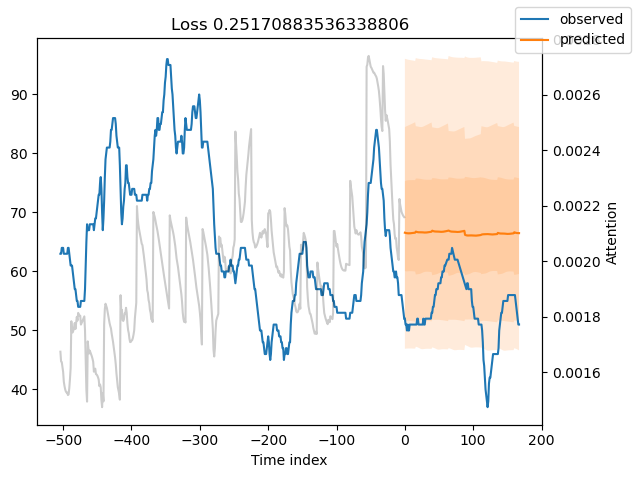

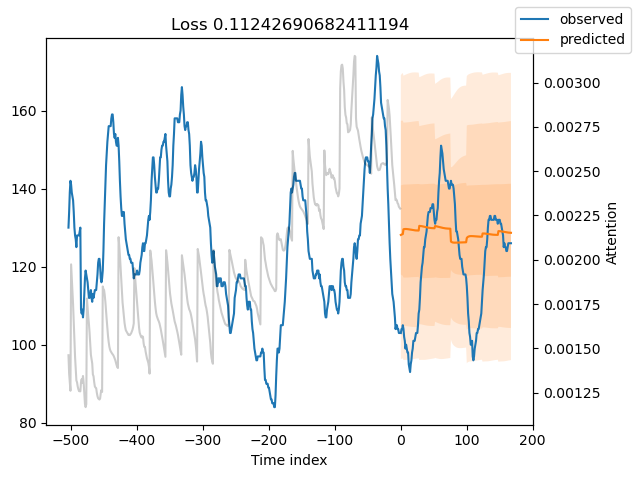

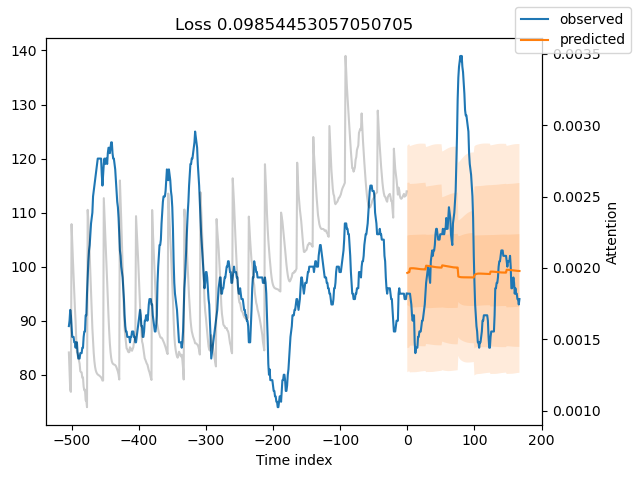

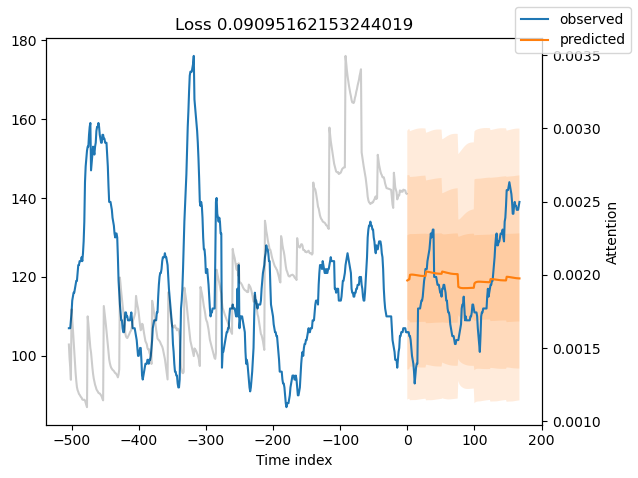

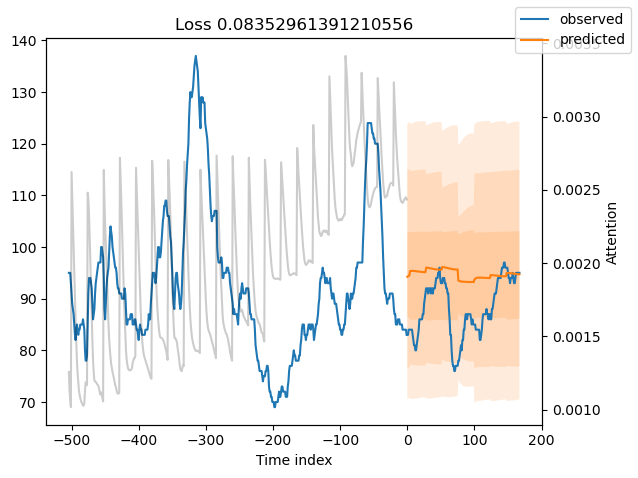

In [71]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'pm25_center': <Figure size 1000x500 with 2 Axes>,
 'pm25_scale': <Figure size 1000x500 with 2 Axes>,
 'hour': <Figure size 1000x500 with 2 Axes>,
 'dayofweek': <Figure size 1000x500 with 2 Axes>,
 'quarter': <Figure size 1000x500 with 2 Axes>,
 'month': <Figure size 1000x500 with 2 Axes>,
 'year': <Figure size 1000x500 with 2 Axes>,
 'dayofyear': <Figure size 1000x500 with 2 Axes>,
 'dayofmonth': <Figure size 1000x500 with 2 Axes>,
 'weekofyear': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'pm25': <Figure size 1000x500 with 2 Axes>,
 'stasiun': <Figure size 640x480 with 2 Axes>}

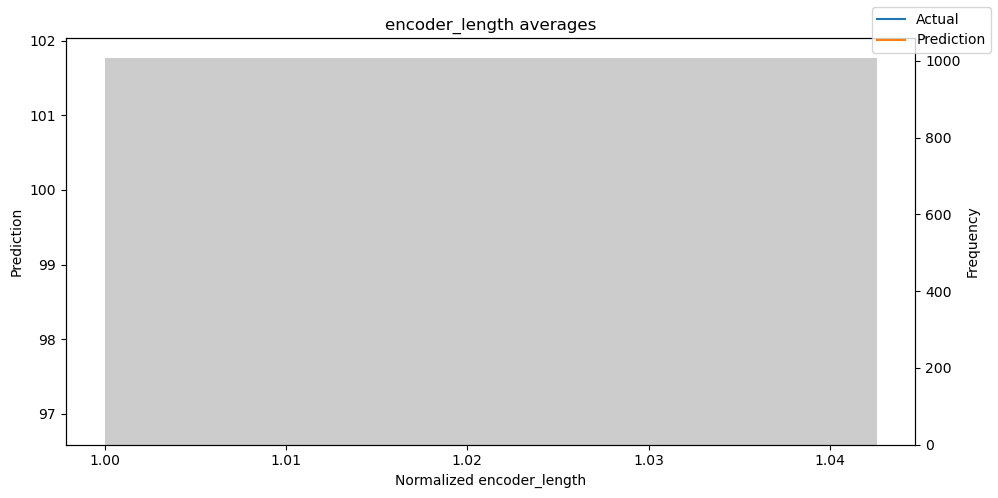

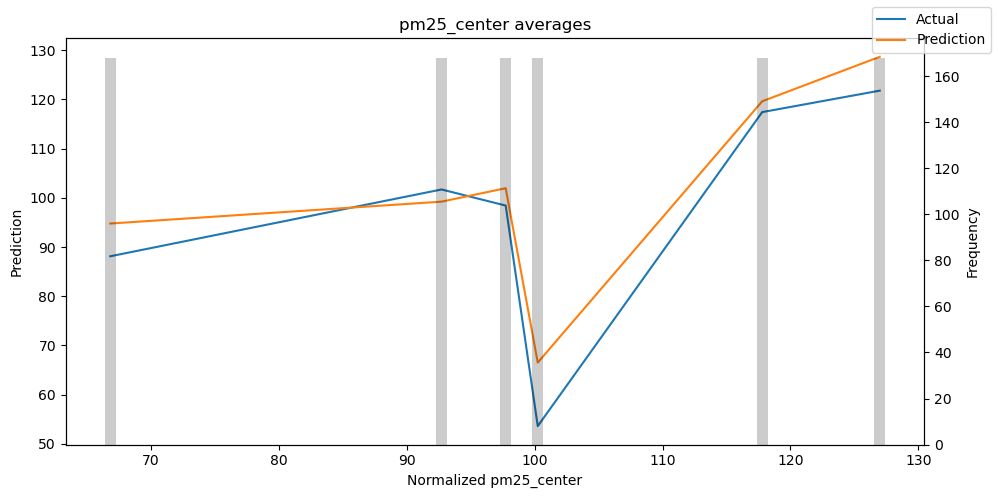

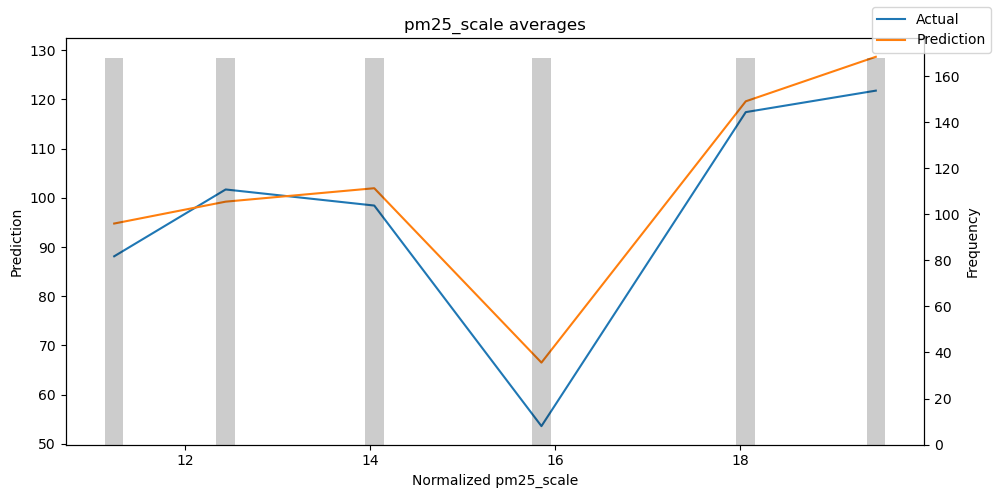

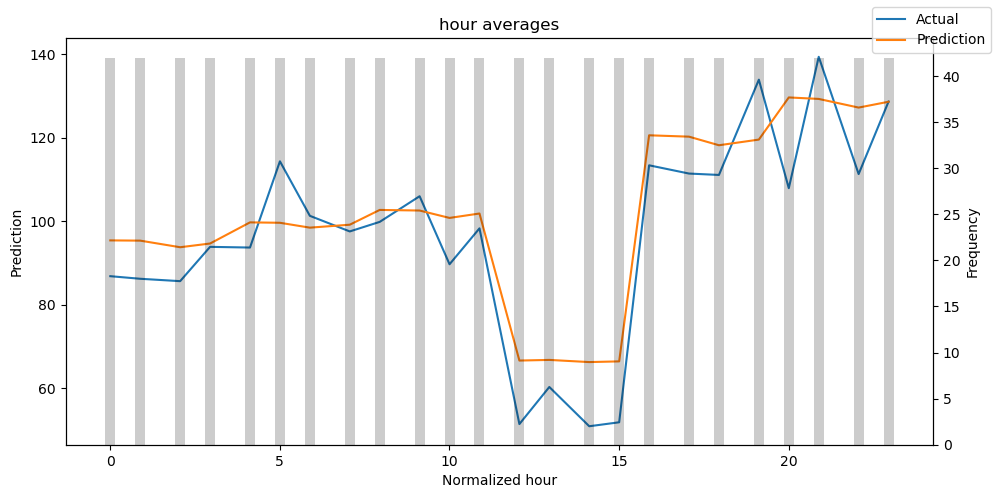

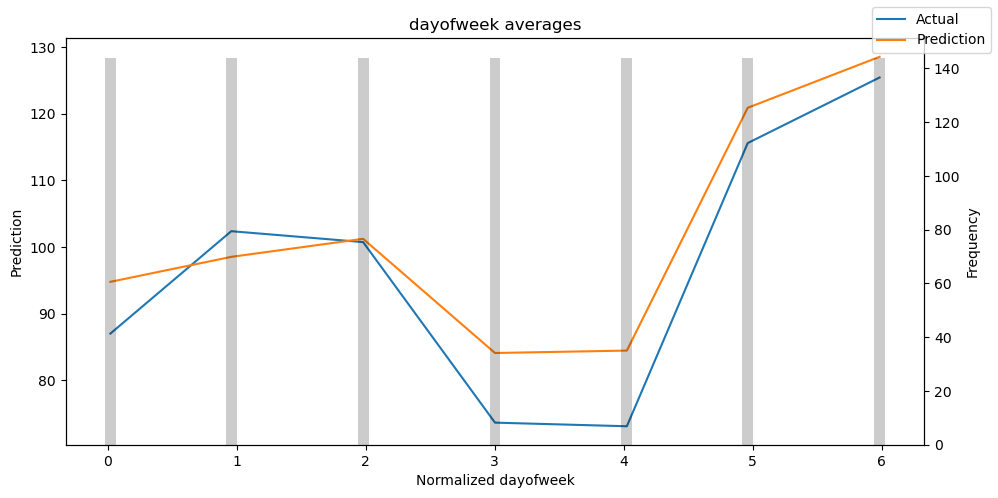

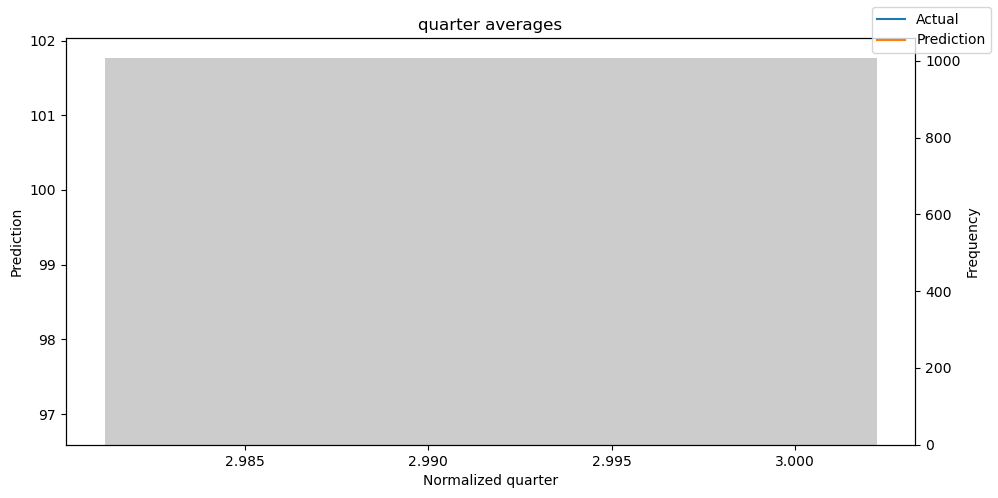

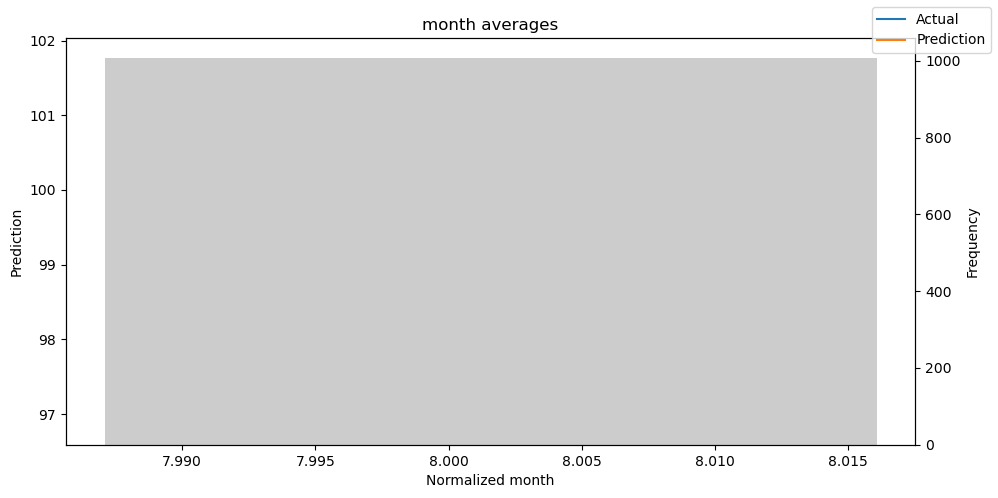

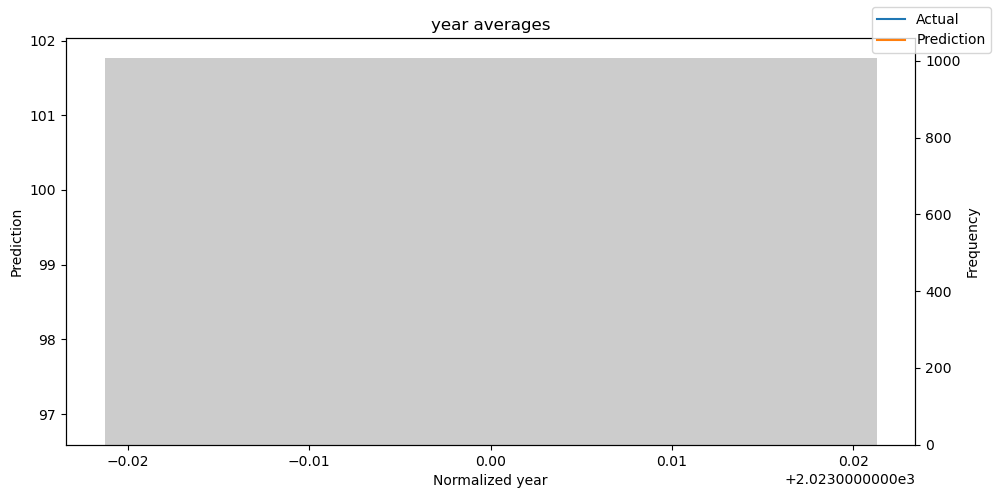

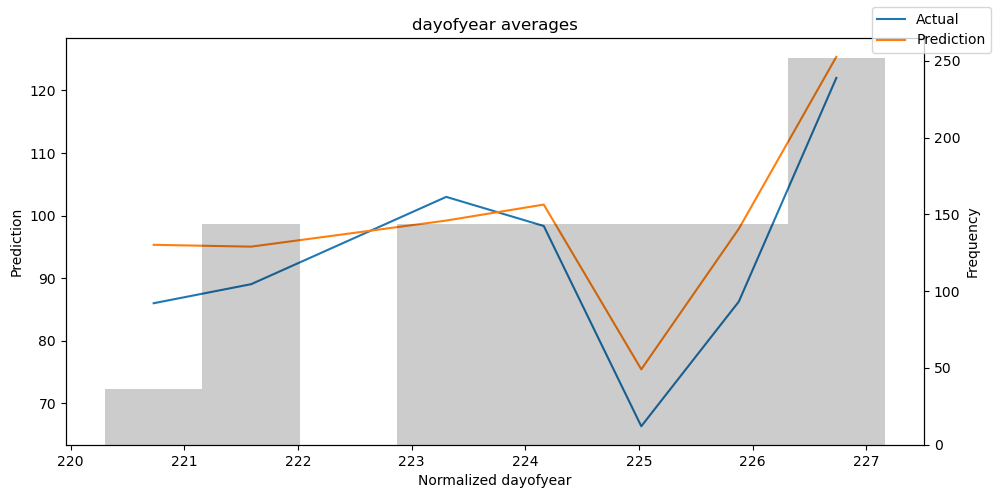

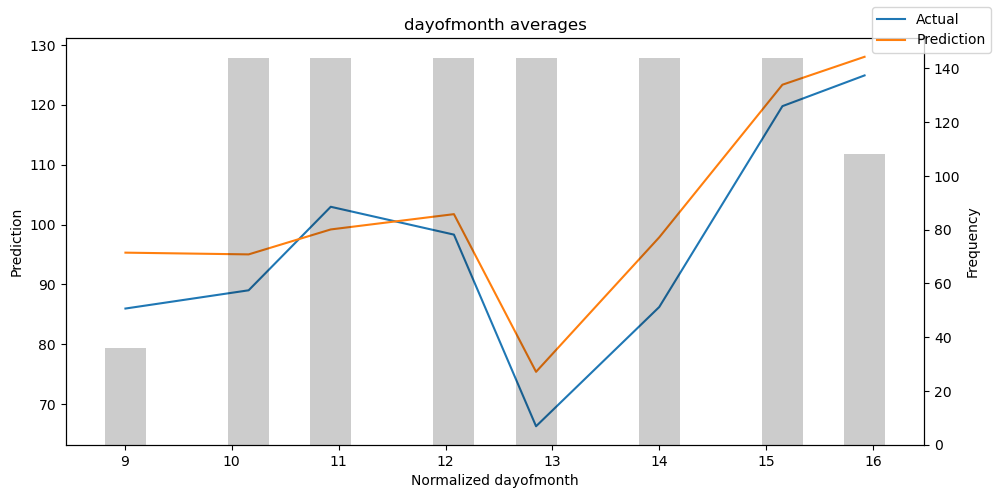

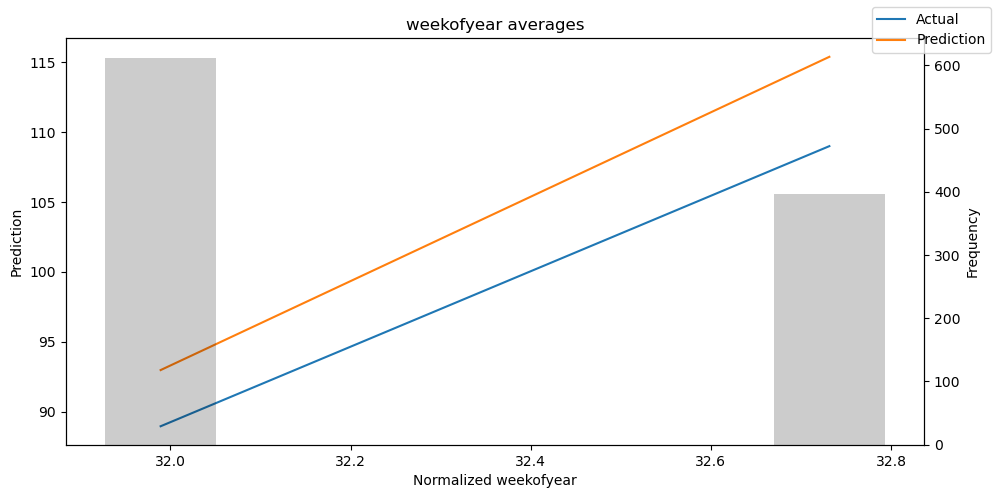

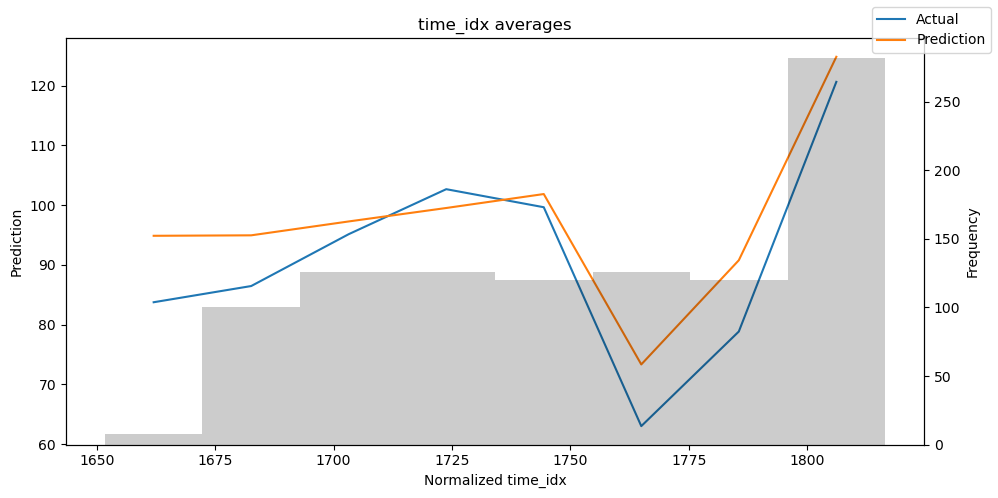

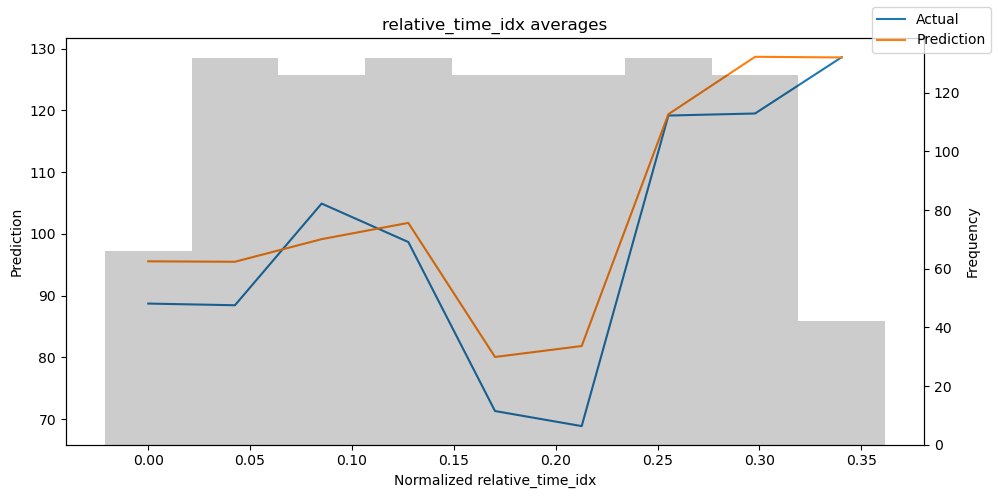

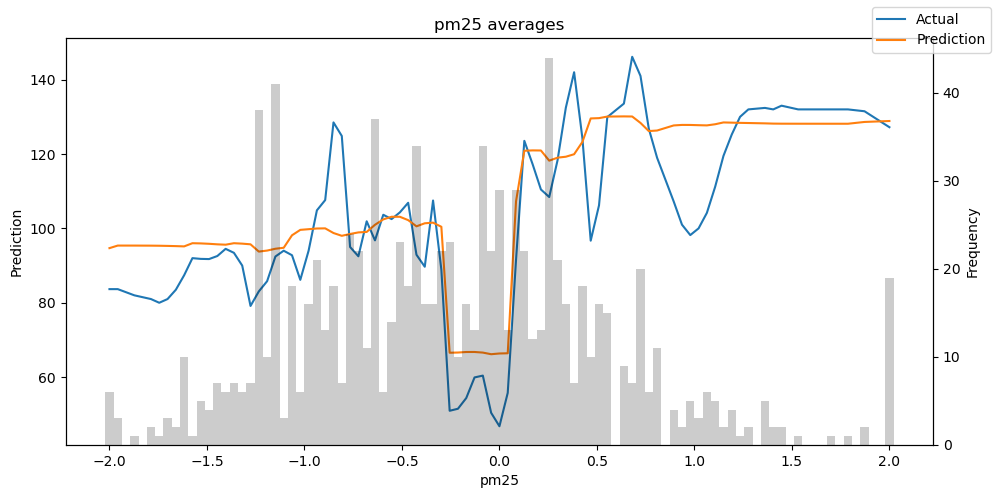

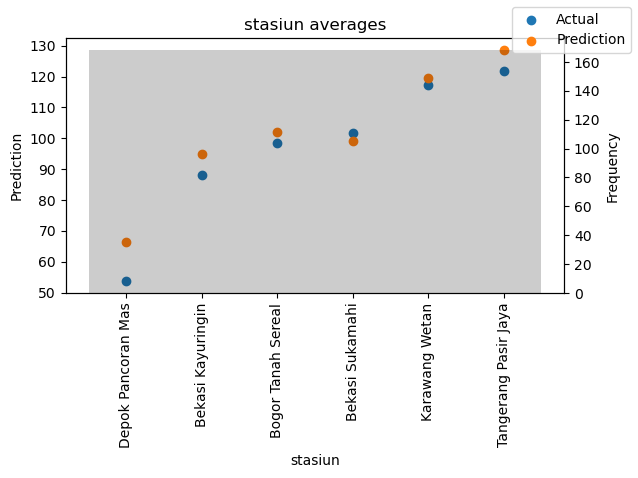

In [72]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

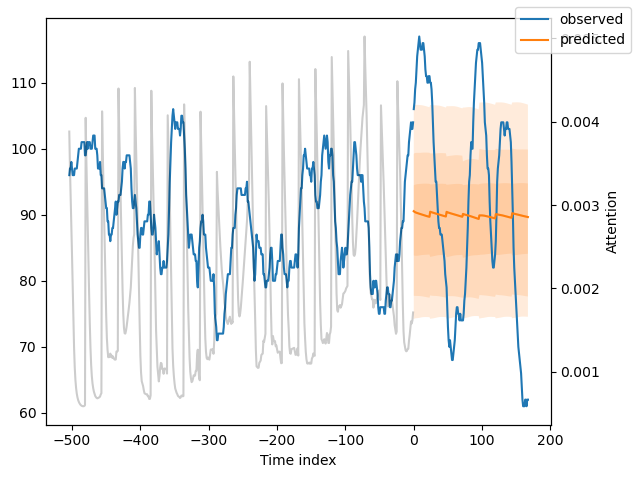

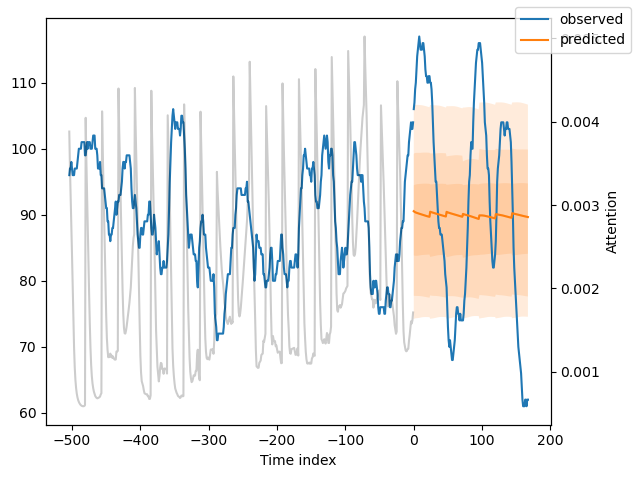

In [74]:
raw_prediction = best_tft.predict(
    training.filter(
        lambda x: (x.stasiun == "Bekasi Kayuringin") 
        # & (x.time_idx_first_prediction == 15)
    ),
    training,
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu")
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

In [77]:
testing = TimeSeriesDataSet(
    test_df,
    time_idx='time_idx',
    target='pm25',
    group_ids=['stasiun'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['stasiun'],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    # time_varying_known_categoricals=["quarter","month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=time_varying_known_reals,
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['pm25'],
    # target_normalizer=GroupNormalizer(
    #     groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [79]:
new_raw_predictions = best_tft.predict(
    testing, mode="raw", return_x=True,
    trainer_kwargs=dict(accelerator="cpu")
    )

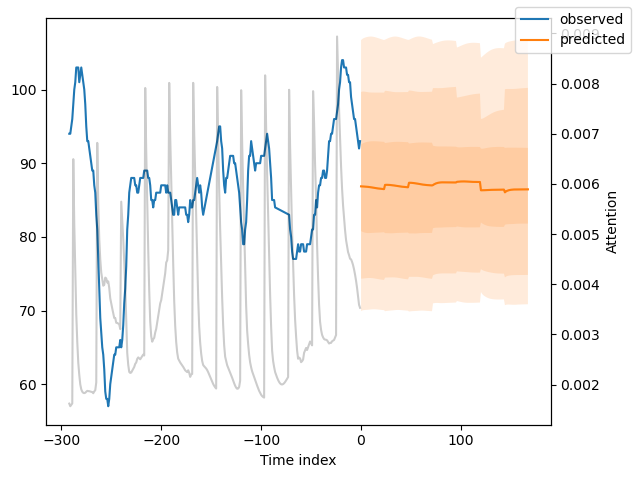

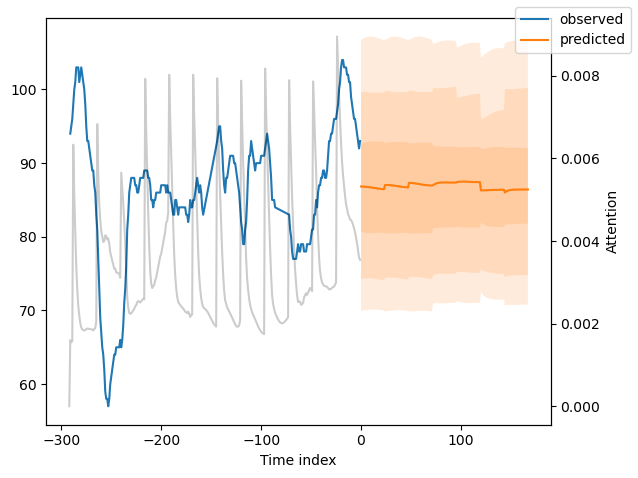

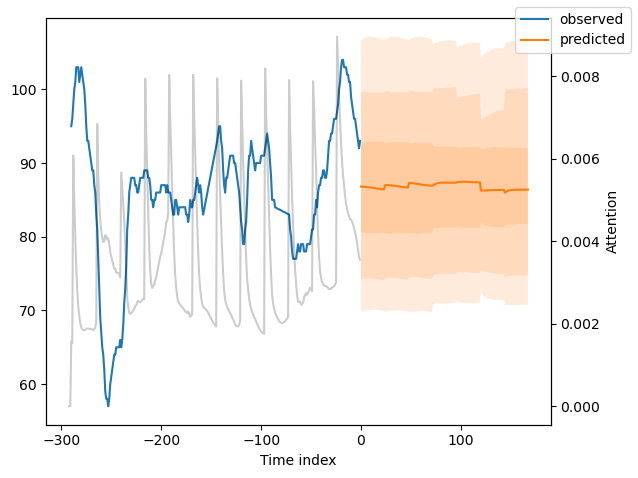

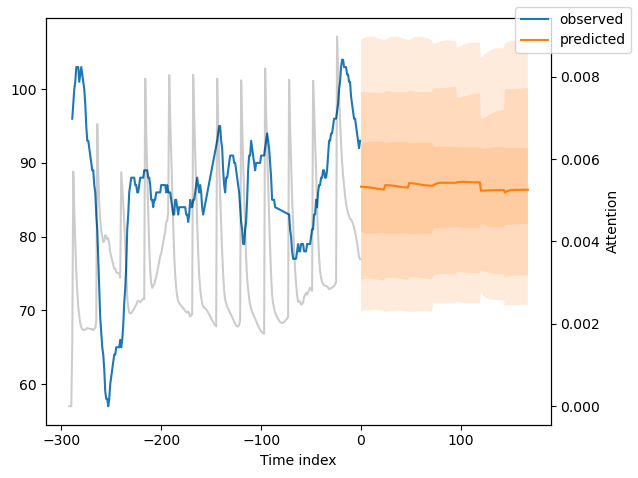

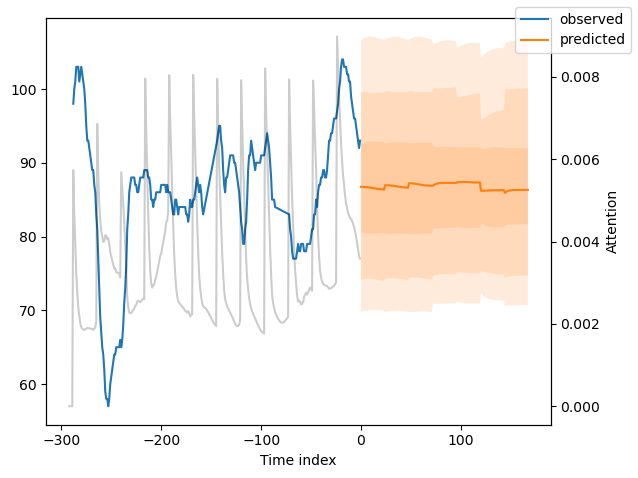

In [80]:
for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=idx, show_future_observed=False)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x475 with 1 Axes>,
 'decoder_variables': <Figure size 700x450 with 1 Axes>}

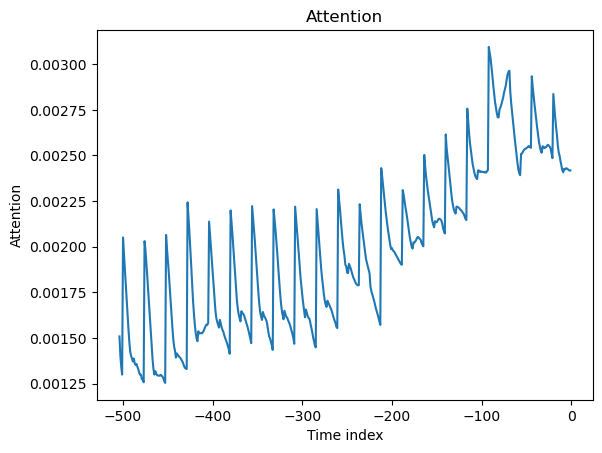

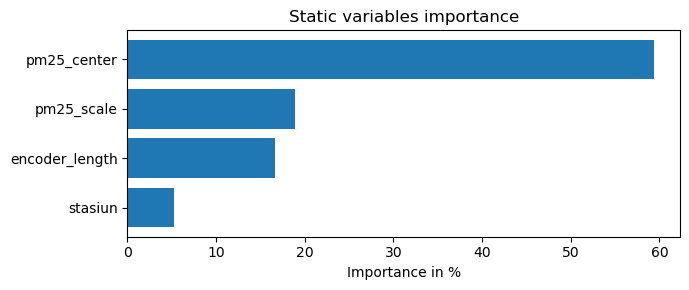

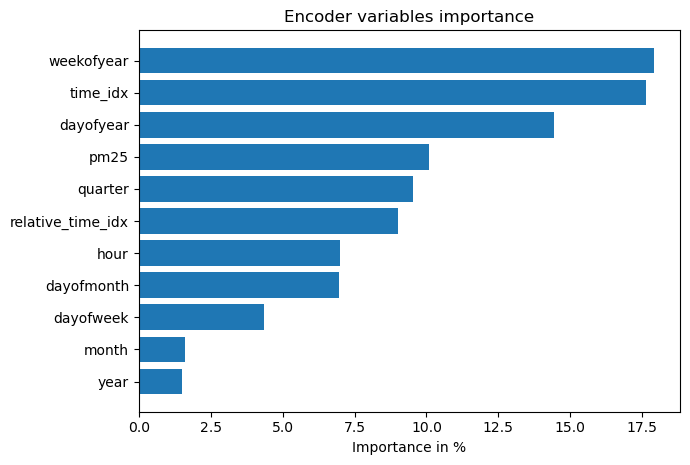

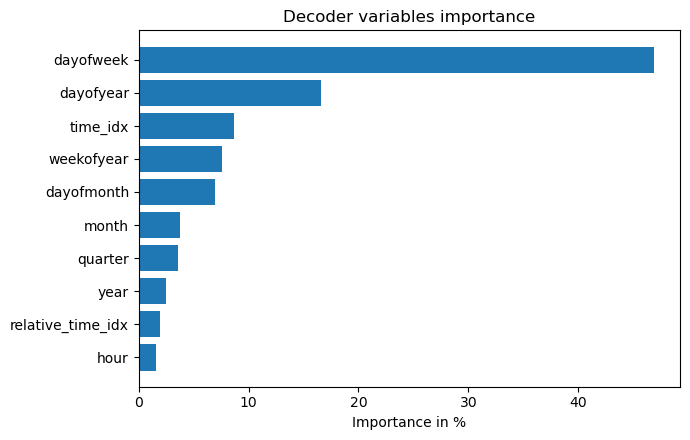

In [81]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [82]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "dayofmonth", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

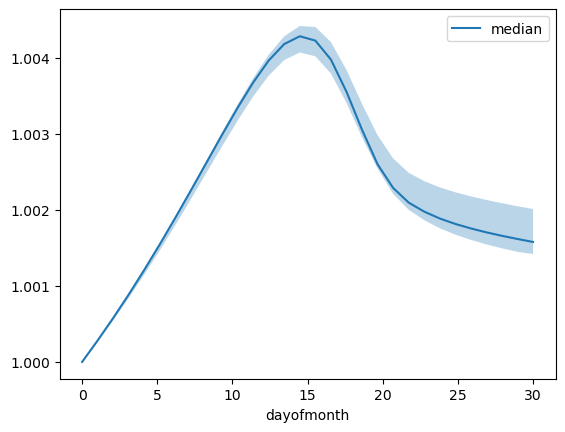

In [83]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("dayofmonth").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)